# Applying pre-trained super-resolution models on images from different datasets

## Setup

In [ ]:
! pip install ISR 

In [ ]:
from google.colab import drive
import os, shutil, zipfile, subprocess
from pathlib import Path
import numpy as np
import PIL, gdal
import matplotlib.pyplot as plt
from ISR.models import RDN, RRDN

In [ ]:
drive.mount('/content/drive')

In [ ]:
dir_mydrive = Path('/content/drive/My Drive')
dir_project = dir_mydrive/'omdena_engie'
dir_sg = (dir_mydrive/'Official Folder for Engie project'/
          'Data'/'Satellite Imagery'/'Main Island'/'JPEG_tiles_Main')
dir_wellington = dir_project/'lds-wellington-010m-urban-aerial-photos-2017-JPEG'

In [ ]:
dir_spacenet_raw = (dir_mydrive/'Official Folder for Engie project'/
                    'task_6_image-resolution'/'SpaceNet raw data')
places = ((4, 'Shanghai'), (3, 'Paris'), (2, 'Vegas'), (5, 'Khartoum'))

## Useful functions

In [ ]:
Path.ls = lambda x: list(x.iterdir())

In [ ]:
def convert_to_8Bit(inputRaster, outputRaster,
                           outputPixType='Byte',
                           outputFormat='GTiff',
                           rescale_type='rescale',
                           percentiles=[2, 98]):
    '''
    Convert 16bit image to 8bit
    rescale_type = [clip, rescale]
        if clip, scaling is done strictly between 0 65535 
        if rescale, each band is rescaled to a min and max 
        set by percentiles
    '''    
    srcRaster = gdal.Open(inputRaster)
    cmd = ['gdal_translate', '-ot', outputPixType, '-of', 
           outputFormat]
    
    # iterate through bands
    for bandId in range(srcRaster.RasterCount):
        bandId = bandId+1
        band = srcRaster.GetRasterBand(bandId)
        if rescale_type == 'rescale':
            bmin = band.GetMinimum()        
            bmax = band.GetMaximum()
            # if not exist minimum and maximum values
            if bmin is None or bmax is None:
                (bmin, bmax) = band.ComputeRasterMinMax(1)
            # else, rescale
            band_arr_tmp = band.ReadAsArray()
            bmin = np.percentile(band_arr_tmp.flatten(), percentiles[0])
            bmax= np.percentile(band_arr_tmp.flatten(), percentiles[1])        
        else:
            bmin, bmax = 0, 65535        
                
        cmd.append('-scale_{}'.format(bandId))
        cmd.append('{}'.format(bmin))
        cmd.append('{}'.format(bmax))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(255))    

    cmd.append(inputRaster)
    cmd.append(outputRaster)
    print("Conversin command:", cmd)
    subprocess.call(cmd)

In [ ]:
# with zipfile.ZipFile(dir_mydrive/'omdena_engie'/'lds-wellington-010m-urban-aerial-photos-2017-JPEG.zip', mode='r') as f:
#     f.extractall(dir_mydrive/'lds-wellington-010m-urban-aerial-photos-2017-JPEG')

## Pre-trained models

In [ ]:
scale_rrdn = 4
scale_rdn = 2

In [ ]:
rrdn = RRDN(weights='gans')
rdn_nc = RDN(weights='noise-cancel')
rdn_psnrsmall = RDN(weights='psnr-small')
rdn_psnrlarge = RDN(weights='psnr-large')

66076672/66071288 [==============================] - 3s 0us/step


## On an xView2 image (.3 m resolution)

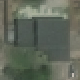

In [ ]:
img = np.array(PIL.Image.open(dir_project/'190814-O-ZZ999-221.JPG'))
img = PIL.Image.fromarray(img[240:320,170:250])
img

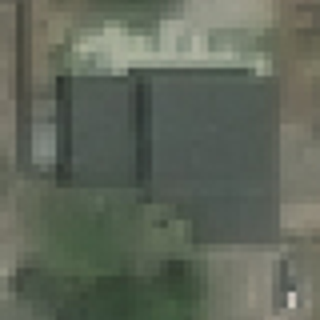

In [ ]:
img.resize(size=tuple(scale_rrdn * s for s in img.size), resample=PIL.Image.BICUBIC)

In [ ]:
%%time
sr_img_gans_xview = rrdn.predict(np.array(img), by_patch_of_size=50)

CPU times: user 5.42 s, sys: 82.2 ms, total: 5.5 s
Wall time: 2.92 s


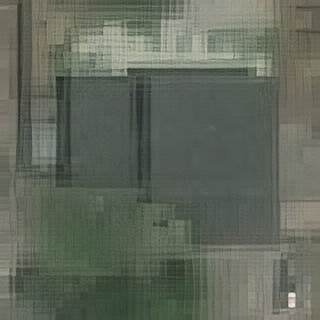

In [ ]:
PIL.Image.fromarray(sr_img_gans_xview)

## On a SpacenetV2 image (.3 m resolution)

In [ ]:
aoi, name = places[2]
dir_place = (dir_spacenet_raw/f'AOI_{aoi}_{name}_Train'/'RGB-PanSharpen')

In [ ]:
dir_place.ls()

[PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img2636.tif'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5184.tif'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img802.tif'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1488.tif'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img246.tif'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie proje

In [ ]:
imgid = 5184
convert_to_8Bit(str(dir_place/f'RGB-PanSharpen_AOI_{aoi}_{name}_img{imgid}.tif'), 
                'test_8bit.tif', 
                rescale_type='rescale', percentiles=[2, 98])

Conversin command: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-scale_1', '123.0', '775.0', '0', '255', '-scale_2', '285.0', '1029.0', '0', '255', '-scale_3', '255.0', '724.0', '0', '255', '/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5184.tif', 'test_8bit.tif']


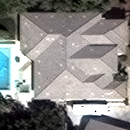

In [ ]:
img = np.array(PIL.Image.open('test_8bit.tif'))[170:300,330:460]
img = PIL.Image.fromarray(img)
img

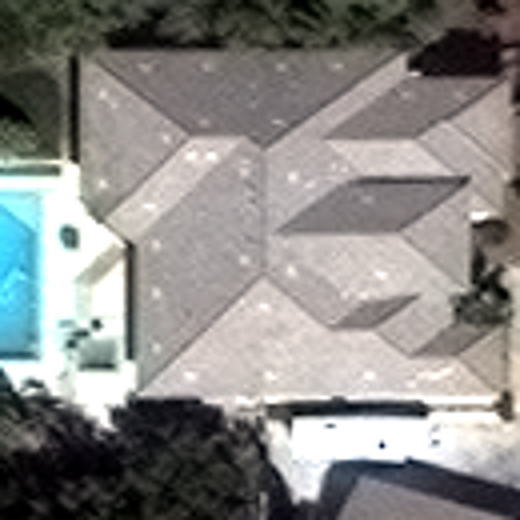

In [ ]:
sr_size = tuple(scale_rrdn * s for s in img.size)
img.resize(size=sr_size, resample=PIL.Image.BICUBIC)

In [ ]:
%%time
sr_img_gans_spacenet = rrdn.predict(np.array(img), by_patch_of_size=50)

CPU times: user 12.1 s, sys: 122 ms, total: 12.2 s
Wall time: 6.31 s


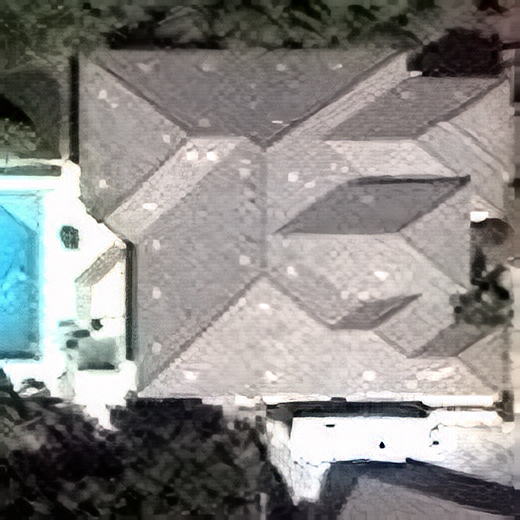

In [ ]:
PIL.Image.fromarray(sr_img_gans_spacenet)

## On a Singapore image (.6 m resolution)

In [ ]:
im_sg = np.array(PIL.Image.open(dir_sg/'main_9600_11600.jpeg'))
im_sg.shape, im_sg.dtype

((512, 512, 3), dtype('uint8'))

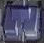

In [ ]:
img = PIL.Image.fromarray(im_sg[23:66,43:87])
img

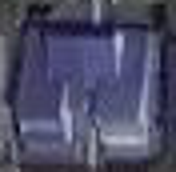

In [ ]:
scaled_size = tuple(scale_rrdn * s for s in img.size)
img.resize(size=scaled_size, resample=PIL.Image.BICUBIC)

In [ ]:
%%time
sr_img_gans_sg = rrdn.predict(np.array(img))

CPU times: user 989 ms, sys: 60.4 ms, total: 1.05 s
Wall time: 633 ms


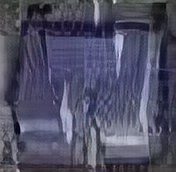

In [ ]:
PIL.Image.fromarray(sr_img_gans_sg)

## On a NZ image (.1 m resolution)

In [ ]:
fn = dir_wellington/'BQ31_500_042079.jpg'

In [ ]:
img = np.array(PIL.Image.open(fn))[1300:1500,450:650]
img = PIL.Image.fromarray(img)

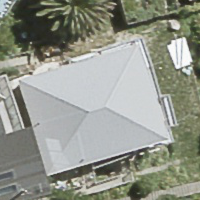

In [ ]:
img

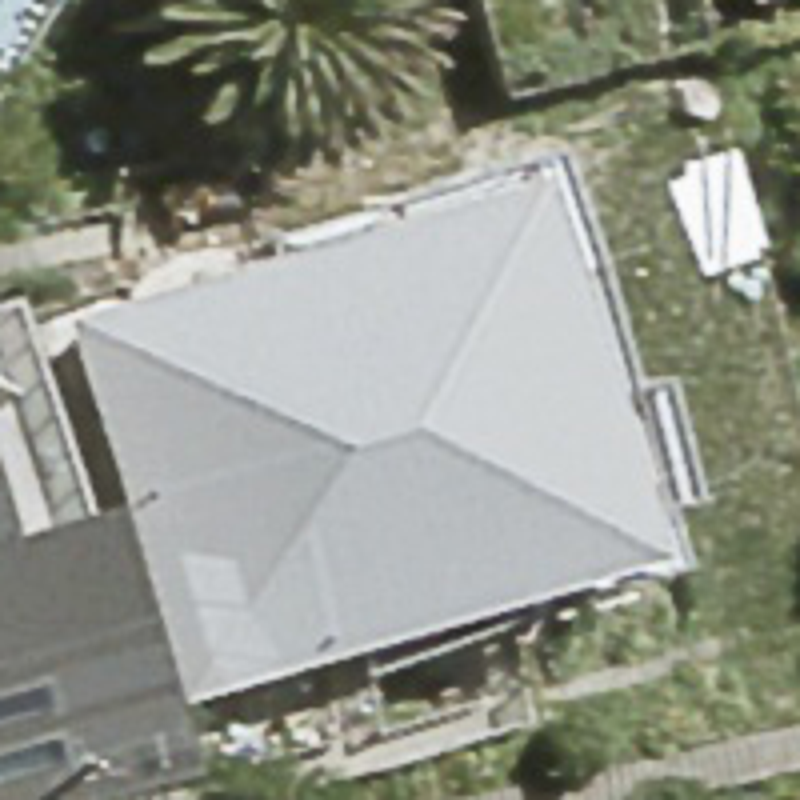

In [ ]:
scaled_size = tuple(scale_rrdn * s for s in img.size)
img.resize(size=scaled_size, resample=PIL.Image.BICUBIC)

In [ ]:
%%time
sr_img_gans_well = rrdn.predict(np.array(img), by_patch_of_size=50)

CPU times: user 21.5 s, sys: 197 ms, total: 21.7 s
Wall time: 11.3 s


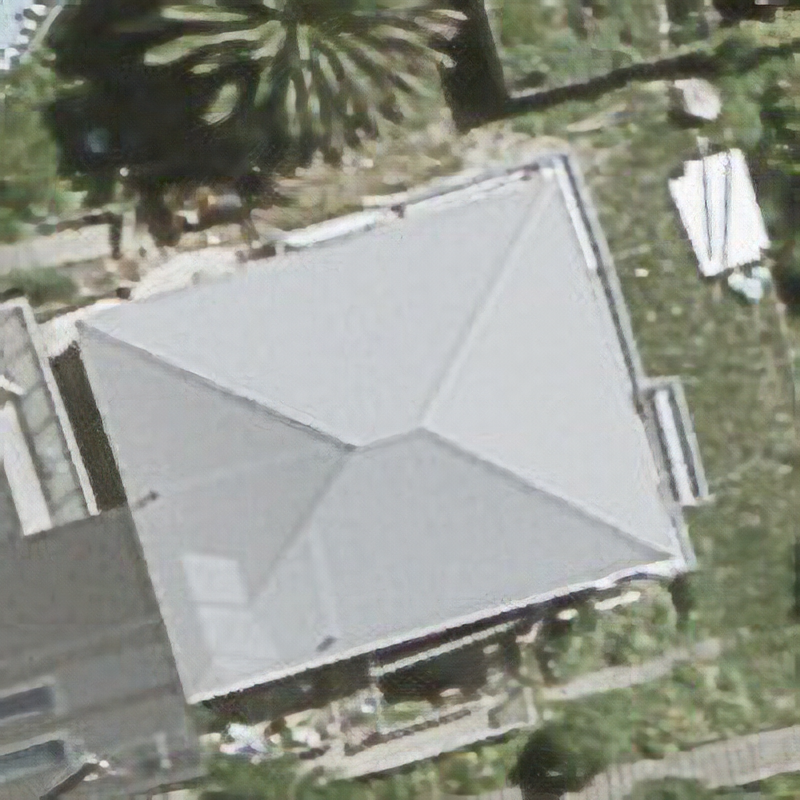

In [ ]:
PIL.Image.fromarray(sr_img_gans_well)

## Reference

* [idealo/image-super-resolution](https://github.com/idealo/image-super-resolution)
* [ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks](https://arxiv.org/abs/1809.00219)
* [Residual Dense Network for Image Super-resolution](https://arxiv.org/pdf/1802.08797.pdf)